In [5]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import networkx as nx
import random
from skimage.util import view_as_blocks
import queue
from tqdm.notebook import tqdm
from time import sleep
import math
import random

In [308]:
N_PROBES = 10
N_ITERATIONS = 100
PATCH_SIZE = [128,128]
STOCHASTIC_SAMPLING = 0

sense_distance = 1
n_directions = 10
search_range = math.pi
step_size = 1
steering_rate = 0.1

In [309]:
TRACE_PATH = 'trace.npy'

print('Number of probes:', N_PROBES)
print('Patch Size:', PATCH_SIZE)

Number of probes: 10
Patch Size: [128, 128]


In [310]:
def probe_propogation(TRACE_PATH, N_ITERATIONS, N_PROBES, STOCHASTIC_SAMPLING, PATCH_SIZE, sense_distance, sense_angle, step_size, steering_rate):
    
    # Load the trace
    TRACE = np.load(TRACE_PATH)
    
    # Initialize a Graph
    G = nx.Graph()
    
    # Take a small patch of Trace field
    patch = np.copy(TRACE[0:PATCH_SIZE[0],0:PATCH_SIZE[1],:])
    DOMAIN_SIZE = [PATCH_SIZE[0]-1,PATCH_SIZE[1]-1]
    
    probe_field = np.zeros((N_PROBES, 4))
    probe_field[:, 0] = default_rng().uniform(low=0.0, high=DOMAIN_SIZE[0], size=probe_field.shape[0])
    probe_field[:, 1] = default_rng().uniform(low=0.0, high=DOMAIN_SIZE[1], size=probe_field.shape[0])
    probe_field[:, 2] = default_rng().uniform(low=0.0, high=2.0*np.pi, size=probe_field.shape[0])
    probe_field[:, 3] = 1.0
    
    angle_queue = queue.Queue(maxsize=3)
    pos_dict = {}
    last = 0
    second_last = 0
    past_pos = []

    
    def world_to_grid_2D(pos_world, size_world, size_grid):
        return (pos_world / size_world) * (size_grid)

    def angle_to_dir_2D(angle):
        return np.array([math.cos(float(angle)), math.sin(float(angle))])

    def custom_mod(a, b):
        return (a - b * math.floor(a / b))
    
    def nodes_connected(u, v):
        return u in G.neighbors(v)
    
    def distance(pos1, pos2):
        return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

    for probe in range(N_PROBES):
        # Initialize probe's starting position
        pos1, pos2, angle, weight = probe_field[probe]
        pos = [pos1, pos2]
        momentum = 1
        
        for i in range(N_ITERATIONS):
            # Make N steps with the probe by calculating the direction forward
            dir_fwd = angle_to_dir_2D(angle)
            t_fwd = world_to_grid_2D(pos + sense_distance * dir_fwd, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
            trace_fwd = (patch[t_fwd[0].astype(int)][t_fwd[1].astype(int)][0])
            
            trace_mut_set = []
            
            # Calculate the direction towards which maximum trace is available, out of n directions
            for k in range(1, n_directions, 1):
                r = search_range / k # searches in a range of 180 degrees
                dir_mut = angle_to_dir_2D(r)
                t_mut = world_to_grid_2D(pos + sense_distance * dir_mut, np.array(DOMAIN_SIZE), np.array(DOMAIN_SIZE))
                trace_mut_set.append(patch[t_mut[0].astype(int)][t_mut[1].astype(int)][0])
                
            trace_mut = max(trace_mut_set)
            angle_mut = 3/(np.argmax(trace_mut_set) + 1)
                
            
            angle_new = 0.0
            
            
            # Calculating the forward angle
            if (trace_fwd > trace_mut):
                angle_new = (angle)
            else:
                angle_new = (steering_rate * angle_mut + (1.0-steering_rate) * angle)
            
            
            # Adding Nodes and edges
            if(G.number_of_nodes() == 0):
                G.add_node(str(i)+'_'+str(probe), position=(pos1, pos2))
                angle_queue.put(angle_new)
                last = str(i)+'_'+str(probe)
            else:
                if abs(angle_new - angle_queue.queue[0]) > 0.10:
                    second_last = last
                    last = str(i)+'_'+str(probe)
                    
                    G.add_node(str(i)+'_'+str(probe), position=(pos1, pos2))
                    
                    # Add an edge only if the noes belong to the same probe
                    if(last.split("_")[-1] == second_last.split("_")[-1]):
                        G.add_edge(last, second_last, length=distance(past_pos, pos))
                    
                    if(angle_queue.qsize() == 3):
                        angle_queue.get()
                    angle_queue.put(angle_new)

            dir_new = angle_to_dir_2D(angle_new)   
            past_pos = [pos1, pos2]

            pos_new = past_pos + step_size * dir_new
            pos_new[0] = custom_mod(pos_new[0], DOMAIN_SIZE[0])
            pos_new[1] = custom_mod(pos_new[1], DOMAIN_SIZE[1])

            probe_field[probe][0] = pos_new[0]
            probe_field[probe][1] = pos_new[1]
            probe_field[probe][2] = angle_new
            
            pos = pos_new
            pos1 = pos_new[0]
            pos2 = pos_new[1]
            angle = angle_new
            

    # Post Processing Steps
    #
    # 1. Remove any edges that have a distance greater than 1.5 pixels
    # 2. Remove any nodes without position values

    for k in list(G.edges):
        if(G[k[0]][k[1]]['length'] > 1.5):
            G.remove_edge(k[0], k[1])
            
    remove = [position[0] for position in G.nodes.data("position") if position[1] == None]
    G.remove_nodes_from(remove)
    
    # Rotate and flip patch to match the positional coordinates of graph
    
    patch_underlay = patch[:,:,0]
    patch_underlay = np.rot90(patch_underlay)
    patch_underlay = np.flipud(patch_underlay)
    
    return G, patch_underlay, dict(G.nodes.data("position"))

In [311]:
graph, patch, positions = probe_propogation(TRACE_PATH, N_ITERATIONS, N_PROBES, STOCHASTIC_SAMPLING, PATCH_SIZE, sense_distance, sense_angle, step_size, steering_rate)

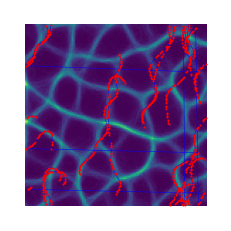

In [312]:
plt.imshow(patch)
nx.draw(graph, pos=positions,
        arrowstyle='->',
        arrowsize=20,
        width=0.5,
        with_labels=False, 
        node_size=1.0,
        node_color='red',
        edge_color='blue')
# nx.draw_networkx_nodes(graph, pos=positions,
#         node_size=1.0, 
#         node_color='red')
plt.savefig("test4_5.png", dpi=1000)